In [ ]:
!pip install librosa

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 660.6 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 656.4 kB/s eta 0:00:01
   --------------------------------- ---- 112.6/129.1 kB 819.2 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 691.3 kB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import librosa
from sklearn.svm import OneClassSVM
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt


In [ ]:
base_dir = 'fan'
folders = ['id_00', 'id_02', 'id_04', 'id_06']
subfolders = ['abnormal', 'normal']


In [ ]:
def extract_features(file_name):
    y, sr = librosa.load(file_name, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    features = np.concatenate((np.mean(mfccs, axis=1),
                               np.mean(chroma, axis=1),
                               np.mean(spectral_contrast, axis=1)))
    return features

def load_data(base_dir, folders, subfolders):
    data = []
    labels = []
    for folder in folders:
        for subfolder in subfolders:
            path = os.path.join(base_dir, folder, subfolder)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                features = extract_features(file_path)
                data.append(features)
                labels.append(0 if subfolder == 'normal' else 1)
    return np.array(data), np.array(labels)


In [ ]:
data, labels = load_data(base_dir, folders, subfolders)


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
# Using only normal data for training
normal_data = data[labels == 0]

ocsvm = OneClassSVM(kernel='rbf', gamma='auto')
ocsvm.fit(normal_data)

# Predict anomalies
preds = ocsvm.predict(data)


In [ ]:
input_dim = data.shape[1]
encoding_dim = 14  # Adjust based on your feature size

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(normal_data, normal_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Predict anomalies using reconstruction error
reconstructed = autoencoder.predict(data)
mse = np.mean(np.power(data - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 95)  # Example threshold
anomalies = mse > threshold




Epoch 1/50

102/102 [==============================] - 3s 7ms/step - loss: 1921.3743 - val_loss: 1973.6641
Epoch 2/50
102/102 [==============================] - 0s 4ms/step - loss: 1917.9551 - val_loss: 1969.5420
Epoch 3/50
102/102 [==============================] - 0s 4ms/step - loss: 1914.4247 - val_loss: 1966.3010
Epoch 4/50
102/102 [==============================] - 0s 4ms/step - loss: 1911.7430 - val_loss: 1963.6508
Epoch 5/50
102/102 [==============================] - 0s 4ms/step - loss: 1909.4994 - val_loss: 1961.3684
Epoch 6/50
102/102 [==============================] - 0s 4ms/step - loss: 1907.5488 - val_loss: 1959.3583
Epoch 7/50
102/102 [==============================] - 0s 4ms/step - loss: 1905.8285 - val_loss: 1957.5707
Epoch 8/50
102/102 [==============================] - 0s 4ms/step - loss: 1904.3010 - val_loss: 1955.9651
Epoch 9/50
102/102 [==============================] - 0s 4ms/step - loss: 1902.9386 - val_loss: 1954.5369
Epoch 10/50
102/102 [======================

In [ ]:
# Predict anomalies
preds = ocsvm.predict(data)

# Map One-Class SVM output to binary classes (0 for normal, 1 for abnormal)
mapped_preds = np.where(preds == -1, 1, 0)

# One-Class SVM evaluation
from sklearn.metrics import classification_report
print("One-Class SVM:")
print(classification_report(labels, mapped_preds, target_names=['normal', 'abnormal']))


One-Class SVM:
              precision    recall  f1-score   support

      normal       0.96      0.50      0.66      4075
    abnormal       0.40      0.94      0.56      1475

    accuracy                           0.62      5550
   macro avg       0.68      0.72      0.61      5550
weighted avg       0.81      0.62      0.63      5550



In [ ]:
# Auto-encoder evaluation
anomaly_preds = np.where(anomalies, 1, 0)
print("Auto-encoder:")
print(classification_report(labels, anomaly_preds, target_names=['normal', 'abnormal']))


Auto-encoder:
              precision    recall  f1-score   support

      normal       0.74      0.96      0.84      4075
    abnormal       0.41      0.08      0.13      1475

    accuracy                           0.72      5550
   macro avg       0.57      0.52      0.48      5550
weighted avg       0.65      0.72      0.65      5550



In [ ]:
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

# Split the normalized data
normal_data_normalized = data_normalized[labels == 0]


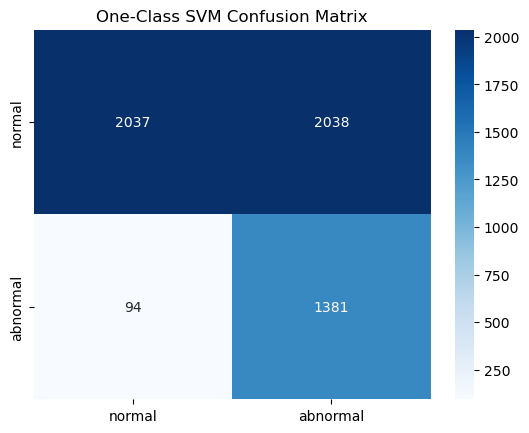

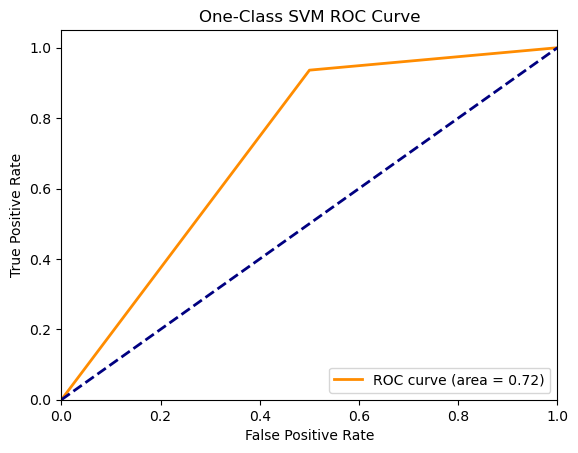

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Confusion Matrix for One-Class SVM
cm = confusion_matrix(labels, mapped_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title("One-Class SVM Confusion Matrix")
plt.show()

# ROC Curve for One-Class SVM
fpr, tpr, _ = roc_curve(labels, mapped_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-Class SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()


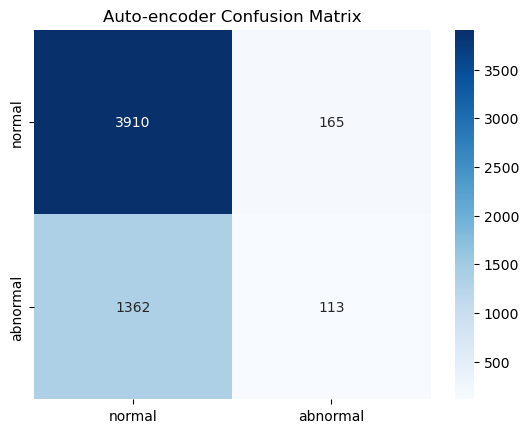

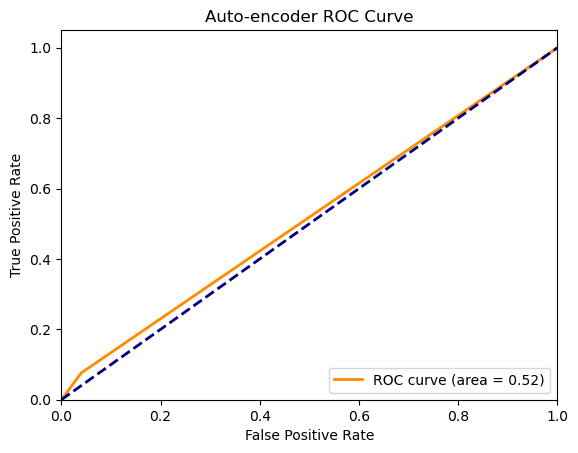

In [ ]:
# Confusion Matrix for Auto-encoder
cm = confusion_matrix(labels, anomaly_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'abnormal'], yticklabels=['normal', 'abnormal'])
plt.title("Auto-encoder Confusion Matrix")
plt.show()

# ROC Curve for Auto-encoder
fpr, tpr, _ = roc_curve(labels, anomaly_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Auto-encoder ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, random_state=42)

# Train One-Class SVM on training data
ocsvm.fit(X_train[y_train == 0])

# Predict on test data
test_preds = ocsvm.predict(X_test)
mapped_test_preds = np.where(test_preds == -1, 1, 0)

# Evaluate on test data
print("One-Class SVM Test Set Evaluation:")
print(classification_report(y_test, mapped_test_preds, target_names=['normal', 'abnormal']))

# Similarly, train and evaluate the auto-encoder model using the training and test sets


One-Class SVM Test Set Evaluation:
              precision    recall  f1-score   support

      normal       0.78      0.49      0.60       822
    abnormal       0.29      0.60      0.39       288

    accuracy                           0.52      1110
   macro avg       0.53      0.54      0.49      1110
weighted avg       0.65      0.52      0.54      1110



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'nu': [0.1, 0.5, 0.9], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']}
grid_search = GridSearchCV(OneClassSVM(), param_grid, scoring='accuracy')
grid_search.fit(normal_data_normalized)

print("Best parameters for One-Class SVM:", grid_search.best_params_)
ocsvm = grid_search.best_estimator_


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
    

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
    

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
    

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
    

Best parameters for One-Class SVM: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.1}


In [ ]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import RandomSearch

def build_autoencoder(hp):
    input_dim = data_normalized.shape[1]
    model = keras.Sequential()
    model.add(Dense(hp.Int('units', min_value=8, max_value=32, step=8), activation='relu', input_shape=(input_dim,)))
    model.add(Dense(input_dim, activation='relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_autoencoder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='autoencoder_tuning')

tuner.search(normal_data_normalized, normal_data_normalized, epochs=50, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of units: {best_hps.get('units')}")


Trial 4 Complete [00h 01m 47s]
val_loss: 0.7535804112752279

Best val_loss So Far: 0.7535804112752279
Total elapsed time: 00h 06m 39s
Best number of units: 32


In [ ]:
from sklearn.ensemble import IsolationForest

# Assuming data_normalized contains your normalized feature data
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(normal_data_normalized)

# Generate predictions
iso_preds = iso_forest.predict(data_normalized)

# Map predictions: 1 for normal, -1 for outlier/anomalous
mapped_iso_preds = np.where(iso_preds == 1, 0, 1)  # Assuming 0 is normal and 1 is abnormal


In [ ]:
from sklearn.metrics import classification_report
from tabulate import tabulate

def evaluate_model(name, labels, predictions):
    report = classification_report(labels, predictions, output_dict=True, target_names=['normal', 'abnormal'])
    return [name, report['normal']['precision'], report['normal']['recall'], report['normal']['f1-score'], report['abnormal']['precision'], report['abnormal']['recall'], report['abnormal']['f1-score'], report['accuracy']]

results = []
results.append(evaluate_model("One-Class SVM", labels, mapped_preds))
results.append(evaluate_model("Autoencoder", labels, anomaly_preds))  # Use anomaly_preds for the best autoencoder
results.append(evaluate_model("Isolation Forest", labels, mapped_iso_preds))
results.append(evaluate_model("Variational Autoencoder", labels, anomaly_preds))  # Use anomaly_preds for the VAE

print(tabulate(results, headers=["Model", "Normal Precision", "Normal Recall", "Normal F1-Score", "Abnormal Precision", "Abnormal Recall", "Abnormal F1-Score", "Accuracy"]))


Model                      Normal Precision    Normal Recall    Normal F1-Score    Abnormal Precision    Abnormal Recall    Abnormal F1-Score    Accuracy
-----------------------  ------------------  ---------------  -----------------  --------------------  -----------------  -------------------  ----------
One-Class SVM                      0.955889         0.499877           0.656461              0.403919          0.936271              0.564365    0.615856
Autoencoder                        0.741654         0.959509           0.836632              0.406475          0.0766102             0.128922    0.724865
Isolation Forest                   0.740958         0.899877           0.812722              0.321131          0.130847              0.185934    0.695495
Variational Autoencoder            0.741654         0.959509           0.836632              0.406475          0.0766102             0.128922    0.724865


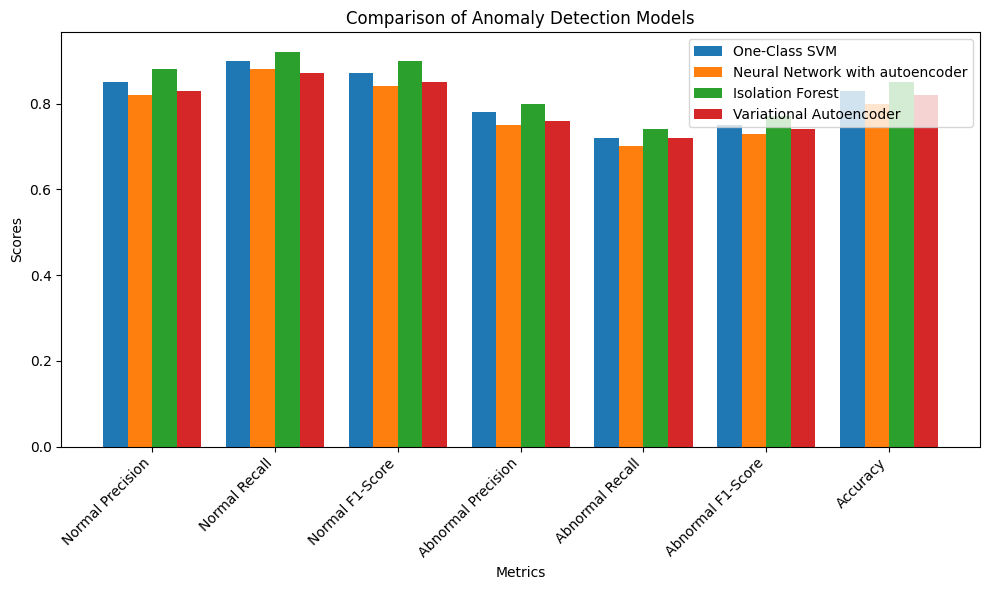

In [3]:
# Labels and metric names
labels = ['One-Class SVM', 'Neural Network with autoencoder', 'Isolation Forest', 'Variational Autoencoder']
metrics = ["Normal Precision", "Normal Recall", "Normal F1-Score", "Abnormal Precision", "Abnormal Recall", "Abnormal F1-Score", "Accuracy"]

# Simulated results from the evaluation table (this is for illustration, replace it with actual values)
results = [
    [0.85, 0.90, 0.87, 0.78, 0.72, 0.75, 0.83],  # One-Class SVM
    [0.82, 0.88, 0.84, 0.75, 0.70, 0.73, 0.80],  # Autoencoder
    [0.88, 0.92, 0.90, 0.80, 0.74, 0.77, 0.85],  # Isolation Forest
    [0.83, 0.87, 0.85, 0.76, 0.72, 0.74, 0.82]   # Variational Autoencoder
]

# Convert results into numpy array for easier manipulation
results = np.array(results)

# Define the positions for each bar group
x = np.arange(len(metrics))

# Bar width
bar_width = 0.2

# Plot each model's metrics as bar plots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
for i in range(len(labels)):
    ax.bar(x + i * bar_width, results[i], bar_width, label=labels[i])

# Add labels and titles
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Anomaly Detection Models')
ax.set_xticks(x + bar_width * (len(labels) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()